In [1]:
import torch
import torch.nn as nn
import random
import numpy as np
import math
import pandas as pd
import seaborn as sns

In [2]:
class LinearNetwork(nn.Module):
    def __init__(self, input_size, num_classes, sizes):
        super().__init__()
        self.sizes = [input_size] + sizes + [num_classes]
        self.layers = nn.Sequential(
            *[nn.Linear(in_f, out_f) for in_f, out_f in zip(self.sizes, self.sizes[1:])])

    def forward(self, x):
        return self.layers(x)

In [3]:
class MLP(nn.Module):
    def __init__(self, input_size, num_classes, sizes, normalization="BatchNorm1d", activation="ReLU", normalization_kwargs=None, activation_kwargs=None):
        super().__init__()
        self.sizes = [input_size] + sizes + [num_classes]
        self.num_layers = len(self.sizes) - 1
        layer_list = []
        for i, (in_f, out_f) in enumerate(zip(self.sizes, self.sizes[1:])):
            layer_list.append(
                nn.Sequential(
                    nn.Linear(in_f, out_f),
                    getattr(nn, normalization)(out_f, **(normalization_kwargs if normalization_kwargs else {})),
                    getattr(nn, activation)(**(activation_kwargs if activation_kwargs else {})) if i+1 < self.num_layers else nn.Identity(out_f),
                )
            )
        self.layers = nn.Sequential(*layer_list)

    def forward(self, x):
        return self.layers(x)

In [4]:
class ConvNet(nn.Module):
    def __init__(self, input_size, num_classes, sizes, normalization="BatchNorm2d", activation="ReLU", kernel_size=3, conv_kwargs=None, normalization_kwargs=None, activation_kwargs=None):
        super().__init__()
        self.sizes = [input_size[0]] + sizes
        self.num_layers = len(self.sizes) - 1
        # convs
        layer_list = []
        for i, (in_c, out_c) in enumerate(zip(self.sizes, self.sizes[1:])):
            layer_list.append(
                nn.Sequential(
                    nn.Conv2d(in_c, out_c, kernel_size=kernel_size, **(conv_kwargs if conv_kwargs else {})),
                    getattr(nn, normalization)(out_c, **(normalization_kwargs if normalization_kwargs else {})),
                    getattr(nn, activation)(**(activation_kwargs if activation_kwargs else {})),
                )
            )
        self.feature_extractor = nn.Sequential(*layer_list)

        n_channels = self.feature_extractor(torch.empty(1, *input_size)).flatten().size(-1)

        self.output = nn.Linear(n_channels, num_classes)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.flatten(start_dim=1)
        x = self.output(x)
        return x

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def count_parameters(net):
    total_param = 0
    for n, p in net.named_parameters():
        if p.requires_grad:
            num_param = p.numel()
            total_param += num_param
    return total_param

def init_weights(net, init, **kwargs):
    for m in net.modules():
        if type(m) in [nn.Linear, nn.Conv2d]:
            getattr(nn.init, init)(m.weight, **kwargs)

In [6]:
def orthogonality_gap(H):
    H = H.flatten(start_dim=1)
    N = H.shape[0]
    D = H.shape[1]
    C = torch.matmul(H,H.transpose(0,1))
    C = C / torch.trace(C)
    gap = torch.norm(C - torch.eye(N).to(C.device)/N, p='fro')
    return gap

class Hook:
    def __init__(self, module, backward=False):
        if not backward:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
        self.input = None
        self.output = None

    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output

    def calculate_rank(self):
        # num of singular values above a given threshold
        return torch.linalg.matrix_rank(self.output)

    def calculate_orthogonality_gap(self):
        return orthogonality_gap(self.output)

    def close(self):
        self.hook.remove()

In [7]:
from torchvision import transforms, datasets
from torch.utils.data import SubsetRandomSampler, DataLoader, Subset, Dataset, SequentialSampler
from utils import DATA_PATH

def get_transform(name, augmentation=False, rsz=None, degrees=None, scale=None, shear=None, **kwargs):
    if name == "MNIST" or name == "FashionMNIST":
        transform_train = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
        transform_test = transform_train
    elif 'CIFAR' in name:
        if augmentation:
            trans = [transforms.RandomCrop(32, padding=4),
                     transforms.RandomHorizontalFlip()]
            if degrees is not None:
                trans.append(transforms.RandomAffine(degrees, scale=scale, shear=shear))
            if rsz is not None:
                trans.append(transforms.Resize(rsz))
        else:
            trans = []
            if rsz is not None:
                trans.append(transforms.Resize(rsz))
        trans += [
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ]
        transform_train = transforms.Compose(trans)

        transform_test = transforms.Compose(trans[-2:])
    elif name == 'SVHN':
        transform_train = transforms.Compose(
            [transforms.ToTensor(),
             #              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
             ])
        transform_test = transform_train
    else:
        raise NotImplementedError('name: {}'.format(name))

    return transform_train, transform_test

def load_dataset(name, **kwargs):
    transform_train, transform_test = get_transform(name, **kwargs)

    trainset = getattr(datasets, name)(root=DATA_PATH, train=True, download=True, transform=transform_train)
    testset = getattr(datasets, name)(root=DATA_PATH, train=False, download=True, transform=transform_test)

    return trainset, testset


def load_trainloader(trainset, seed, batch_size=128, num_workers=0, shuffle=True, valid_ratio=0.2, subset=False):
    g = torch.Generator()
    g.manual_seed(seed)

    if valid_ratio > 0:
        # # divide the training set into validation and training set.
        instance_num = len(trainset)
        if subset:
            instance_num *= subset
        print(f"Num Samples in train + validation: {instance_num}")
        indices = list(range(instance_num))
        split_pt = int(instance_num * valid_ratio)
        train_idx, valid_idx = indices[split_pt:], indices[:split_pt]
        train_sampler, valid_sampler = SubsetRandomSampler(train_idx), SequentialSampler(valid_idx)

        # Note without persistent_workers=True, cost to restart new threads to do loading is brutal.
        train_loader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler, generator=g, num_workers=num_workers, pin_memory=True)
        valid_loader = DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers, pin_memory=True)
    else:
        train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=shuffle, generator=g, num_workers=num_workers, pin_memory=True)
        valid_loader = None

    return train_loader, valid_loader

In [8]:
def add_hooks_linear(net):
    hooks = []
    for m in net.modules():
        if type(m) in [nn.Linear]:
            hooks.append(Hook(m))
    return hooks

### Replicating Figure 1 from - Batch Normalization Provably Avoids Rank Collapse for Randomly Initialised Deep Networks

Note: Default Pytorch init gives far worse results than xavier_normal_ and normal_ init actually gives not to horrible results.

In [23]:
def depth_experiment(data, num_classes, data_shape, seed, width=128, normalization="BatchNorm1d", activation="ReLU", init=None, init_kwargs=None, depth=30, every=1):
    set_seed(seed)
    rank_list = []
    gap_list = []
    depth_list = []
    for d in range(1, depth, every):
        net = MLP(np.prod(data_shape), num_classes, [width]*d, normalization, activation)
        if init:
            init_weights(net, init, **(init_kwargs if init_kwargs else {}))

        hooks = add_hooks_linear(net)

        net(data)

        rank_list.append(hooks[d-1].calculate_rank().item())
        gap_list.append(hooks[d-1].calculate_orthogonality_gap().item())
        depth_list.append(d)

    df = pd.DataFrame([depth_list, rank_list, gap_list]).T
    df = df.rename({0: "depth", 1: "rank", 2: "gap"}, axis=1)
    return df

In [18]:
seed = 0
set_seed(seed)
trainset, testset = load_dataset("FashionMNIST")
train_loader, valid_loader = load_trainloader(trainset, seed, batch_size=128)

num_classes = len(train_loader.dataset.classes)
data_shape = tuple(train_loader.dataset[0][0][0].shape)

train_loader = iter(train_loader)
x_batch, y_batch = next(train_loader)

Num Samples in train + validation: 60000


In [11]:
repeat_df = pd.DataFrame()
for i in range(5):
    net_df = pd.DataFrame()
    for norm in ["BatchNorm1d", "Identity"]:
        df = depth_experiment(x_batch.flatten(start_dim=1), num_classes, data_shape, normalization=norm,seed=i, depth=33)
        df["Norm"] = norm
        net_df = pd.concat([net_df, df])
    net_df['seed'] = i
    repeat_df = pd.concat([repeat_df, net_df])
repeat_df = repeat_df.reset_index()

<AxesSubplot:xlabel='depth', ylabel='gap'>

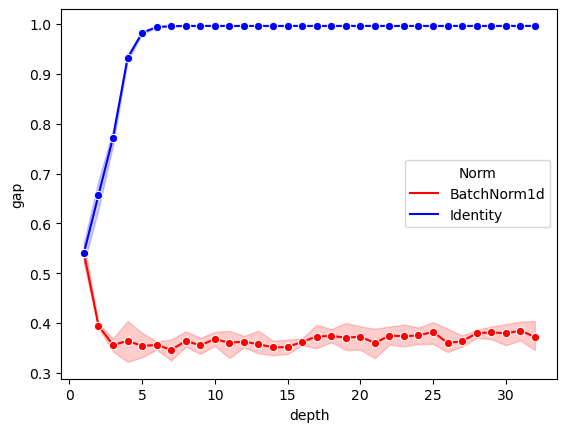

In [12]:
sns.lineplot(data=repeat_df,x="depth",y="gap", hue="Norm", palette=["red", "blue"], marker='o')

<AxesSubplot:xlabel='depth', ylabel='rank'>

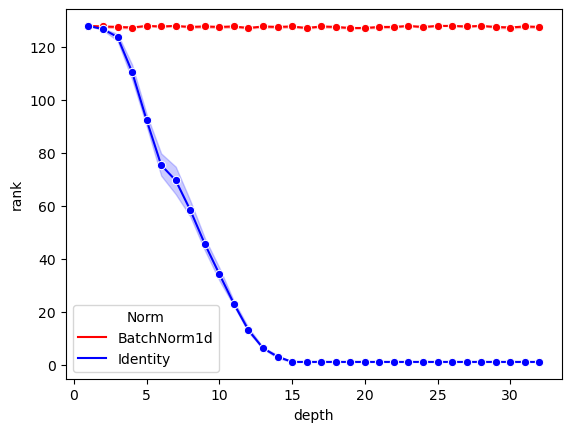

In [13]:
sns.lineplot(data=repeat_df,x="depth",y="rank", hue="Norm", palette=["red", "blue"], marker='o')

### Replicating Figure 2 from - Batch Normalization Provably Avoids Rank Collapse for Randomly Initialised Deep Networks

In [19]:
seed = 0
set_seed(seed)
trainset, testset = load_dataset("FashionMNIST")
train_loader, valid_loader = load_trainloader(trainset, seed, batch_size=128)

num_classes = len(train_loader.dataset.classes)
data_shape = tuple(train_loader.dataset[0][0][0].shape)

train_loader = iter(train_loader)
x_batch, y_batch = next(train_loader)

Num Samples in train + validation: 60000


In [31]:
repeat_df = pd.DataFrame()
for i in range(1):
    net_df = pd.DataFrame()
    for act in ["ReLU", "Identity"]:
        df = depth_experiment(x_batch.flatten(start_dim=1), num_classes, data_shape, seed=i, width=32, activation=act, depth=10000, every=1000)
        df["Activation"] = act
        net_df = pd.concat([net_df, df])
    net_df['seed'] = i
    repeat_df = pd.concat([repeat_df, net_df])
repeat_df = repeat_df.reset_index()

<AxesSubplot:xlabel='depth', ylabel='gap'>

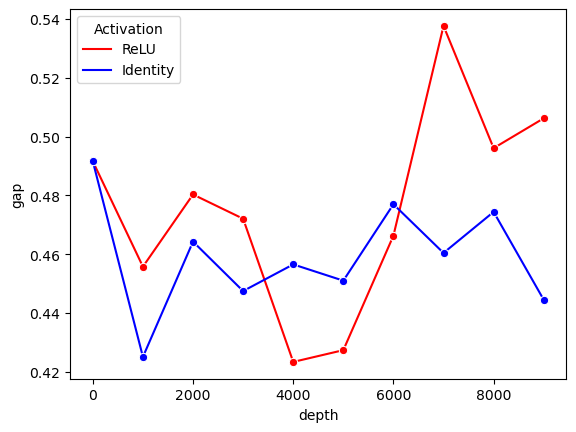

In [32]:
sns.lineplot(data=repeat_df,x="depth",y="gap", hue="Activation", palette=["red", "blue"], marker='o')

<AxesSubplot:xlabel='depth', ylabel='rank'>

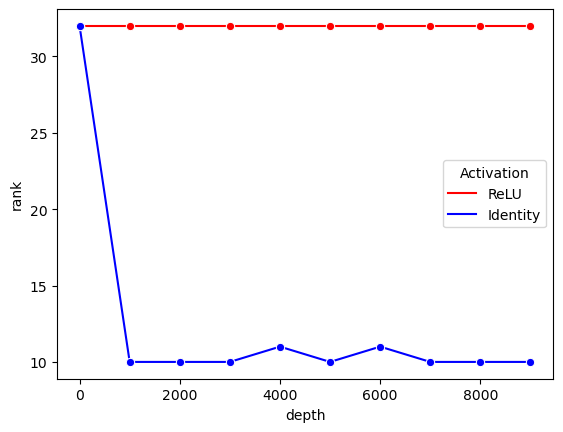

In [33]:
sns.lineplot(data=repeat_df,x="depth",y="rank", hue="Activation", palette=["red", "blue"], marker='o')

### Figure 1 - Batch Normalization Orthogonalizes Representations in Deep Random Networks

$<x, y> = \Vert x \Vert \Vert y \Vert cos(\theta)$ so
$cos(\theta) = \frac{x^T y}{\Vert x \Vert \Vert y \Vert} $

In [90]:
# cosine similarity formula
def cosine_similarity(x, y):
    return np.abs(x.T @ y / (np.linalg.norm(x, 2) * np.linalg.norm(y, 2)))

assert np.allclose(cosine_similarity(np.ones(2), np.ones(2)*.5), 1)
assert np.allclose(cosine_similarity(np.ones(2), np.array([1, -1])), 0)

$H_{l+1} = \frac{1}{\sqrt{d}} BN(W_l H_l)$ where $BN(M) = diag(MM^T)^{-\frac{1}{2}}\odot M$

BN as implemented in pytorch:
$BN_{\gamma^k, \beta^k}(x^k) = \gamma^k \frac{x^k - \mathbb{E}(x^k)}{\sqrt{\sigma^2(x^k)}} + \beta^k$

In [240]:
def batch_norm(X):
    return 1/np.sqrt(X.shape[0])*(1/np.sqrt(np.diag(X @ X.T))).reshape((-1,1)) * X

# diag(X @ X^T) is x_i^T @ x_j for i == j which is l2norm.
def batch_norm_easy(X):
    return 1/np.sqrt(X.shape[0]) * (X.T/np.linalg.norm(X, axis=1)).T

assert np.allclose(batch_norm(np.array([[1,0],[0,5],[0,1]])), 1/np.sqrt(3)*np.array([[1,0],[0,1],[0,1]]))
assert np.allclose(np.linalg.norm(batch_norm(np.array([[1,0],[0,5],[0,1]]).T), 'fro'), 1)
assert np.allclose(batch_norm(np.array([[1,0],[0,5],[0,1]])), batch_norm_easy(np.array([[1,0],[0,5],[0,1]])))

In [244]:
# one for batch norm, one for vanilla
bn_list = []
v_list = []
depth_list = []
repeat = 20
for _ in range(repeat):
    depth = 50
    width = 32
    samples = 2
    in_size = 2
    size = [in_size] + [width]*depth
    x_v = np.zeros((samples,in_size))
    x_bn = np.zeros((samples,in_size))
    eta = 0.001 # small constant

    # create inputs that are not similar (nearly orthogonal) (low cosine similarity)
    x_v[0, 0] = eta
    x_v[0, 1] = 1 - eta
    x_v[1, 0] = 1
    x_v[1, 1] = 0

    # create inputs that are similar (nearly parallel) (high cosine similarity)
    x_bn[0, 0] = eta
    x_bn[0, 1] = 1 - eta
    x_bn[1, 0] = 0
    x_bn[1, 1] = 1

    x_v = x_v.T
    x_bn = x_bn.T
    for d, (w_in, w_out) in enumerate(zip(size, size[1:])):
        v_list.append(cosine_similarity(x_v[:,0], x_v[:,1]))
        bn_list.append(cosine_similarity(x_bn[:,0], x_bn[:,1]))
        depth_list.append(d)

        #W = np.random.normal(0, 1, size=(w_out, w_in))
        W = np.random.randn(w_out, w_in)
        x_v = W @ x_v
        x_bn = W @ x_bn

        # normalize bn
        x_bn = batch_norm_easy(x_bn)

df = pd.DataFrame([depth_list, v_list, bn_list]).T
df = df.rename({0: "depth", 1: "vanilla", 2: "BN"}, axis=1)

In [245]:
df = pd.DataFrame([depth_list, v_list, bn_list]).T
df = df.rename({0: "depth", 1: "vanilla", 2: "BN"}, axis=1)

<AxesSubplot:xlabel='depth', ylabel='vanilla'>

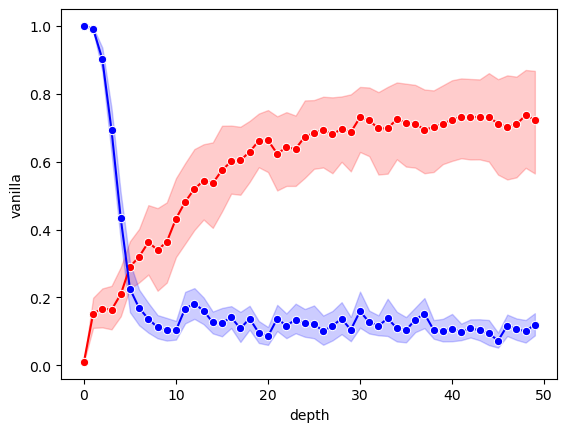

In [246]:
sns.lineplot(data=df,x="depth",y="vanilla",color="red", marker='o')
sns.lineplot(data=df,x="depth",y="BN",color="blue", marker='o')

In [247]:
# move on to testing out something like NASBench -> break up into small chunks
    # set up NASBench
    # be able to enumerate all architectures
    # init method, calculate statistic